# Advanced Tutorial - Fitting Messy Posteriors
`LITMUS`'s default settings are tuned to balance speed and robustness, aiming to quickly fit lags for as many signals as possible. However, it's easy to run across seamingly similar problems where more user-driven fine-tuning is required. The hessian and SVI scans rely on them having a good sample of "test lags" to form their Gaussian slices at. By default, they generate these automatically via the "grid smoothing" algorithm (see the original paper) encoded in the `hessian_scan.make_grid()` method, but in this tutorial we'll show when, and how, to nominate these slices ourselves.

_note:This tutorial using the `hessian_scan` for demonstration, but all steps here are equally applicable with the `SVI_scan` as well. Consider using that if you plan on doing model comparison._  

In [1]:
import litmus.models
from litmus import *
import matplotlib.pyplot as plt
import numpy as np
from litmus._utils import dict_extend

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In this tutorial we'll be using the pre-made `mock_B` from the `litmus.mocks` module. This is a high SNR source with extremely low error on the response signal. Ideally this means that the lag will be well constrained, but it also makes the posterior function sharp and difficult to navigate. In the following, the true underlying lag is $\Delta t = 256 \mathrm(d)$ and the timescale is $\tau = 400 \mathrm{d}$:

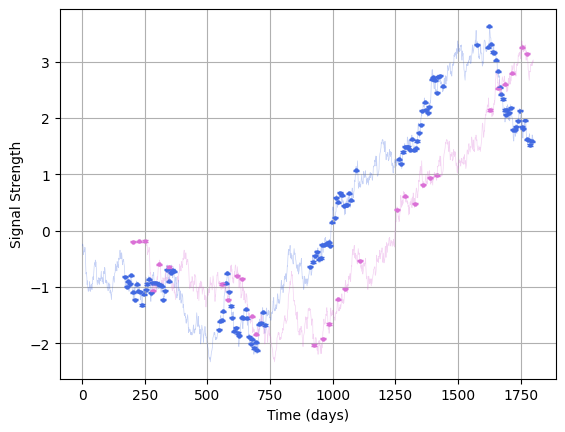

In [2]:
mock = mocks.mock_B
mock.plot()
model_1 = models.GP_simple(verbose=False, debug=False, warn=0)
data = model_1.lc_to_data(mock.lc_1, mock.lc_2)

First lets fit this how we normally would: a smattering of lags with some simple preconditioning to improve the efficiency of the slice solver. In this case I've also made some tweaks to `init_samples` and `grid_bunching` to make the initial posteior estimation closer to a dense grid, and lowered `optimizer_args["maxiter"]`, i.e. shortened the slice optimization regime to make the solver run a bit faster:

In [3]:
fitter = litmus.fitting_methods.hessian_scan(model_1, precondition="diag",
                                             verbose=2, debug=False, warn=1,
                                             Nlags=128,
                                             grid_bunching=0.5,
                                             init_samples=10_000,
                                             optimizer_args={"maxiter": 128, "increase_factor": 1.2}
                                             )
fitter.prefit(mock.lc_1, mock.lc_2)

Using stat model .find_seed to estimate some parameters 
Optimizing Non-Lag Params... 
Moving non-lag params to new location... 
Finding a good lag with grid sweep... 
Doing lag Optimization in isolation... 
Running final optimization... 
Estimated to be within ±1.28e+00σ of local optimum in non-lag parameters,
and within ±infσ of local optimum in all parameters

Making test lags from .make_grid() 
Making Grid with interp scale log 
Prefitting Complete 


Right away we can see something a little concerning. When estimaing the peak for generating the grid, the solver has landed about $1.3$ standard deviations from the local peak and there's some very strange behaviour along the lag axis. If we converge on one but not the other, it usually suggests that there's some odd geometry on the lag axis. Still: let's fire this off and see how it goes:

Starting Hessian Scan 
:::::::::::::::::::::::
Scanning at lag=188.79 ...

Seems to have converged at iteration 0 / 128 with tolerance 2.75e-05 
:::::::::::::::::::::::
Scanning at lag=188.67 ...

Seems to have converged at iteration 1 / 128 with tolerance 1.02e-05 
:::::::::::::::::::::::
Scanning at lag=188.55 ...

Seems to have converged at iteration 2 / 128 with tolerance 4.26e-06 
:::::::::::::::::::::::
Scanning at lag=188.42 ...

Seems to have converged at iteration 3 / 128 with tolerance 1.79e-05 
:::::::::::::::::::::::
Scanning at lag=188.30 ...

Seems to have converged at iteration 4 / 128 with tolerance 2.15e-05 
:::::::::::::::::::::::
Scanning at lag=188.18 ...

Seems to have converged at iteration 5 / 128 with tolerance 1.84e-05 
:::::::::::::::::::::::
Scanning at lag=188.05 ...

Seems to have converged at iteration 6 / 128 with tolerance 1.89e-05 
:::::::::::::::::::::::
Scanning at lag=187.93 ...

Seems to have converged at iteration 7 / 128 with tolerance 6.58e-06 
:

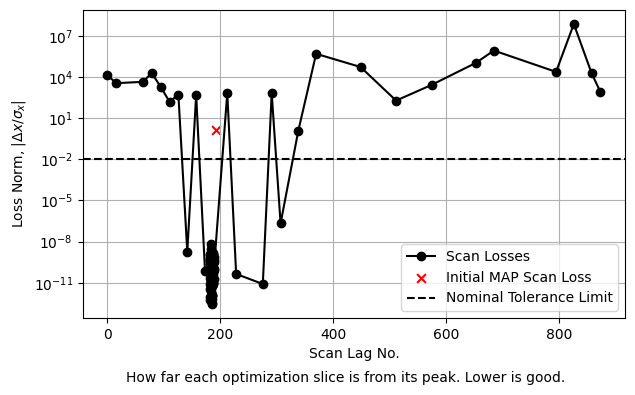

In [4]:
fitter.fit(mock.lc_1, mock.lc_2)
fitter.diagnostics(show=False)
plt.show()

To be safe let's check our diagnostics: it looks like some of our slices are still away from convergence. Let's give them another go. Okay, this looks good! We've got a single densely sampled peak, lots of converged slices, everything's great, right?

Doing re-fitting of 21 lags 
:::::::::::::::::::::::
Refitting lag 0/21 at lag 157.48

Settled at new tol 1.14e-03 
:::::::::::::::::::::::
Refitting lag 1/21 at lag 125.98

Settled at new tol 4.43e-04 
:::::::::::::::::::::::
Refitting lag 2/21 at lag 110.24

Settled at new tol 1.85e-03 
:::::::::::::::::::::::
Refitting lag 3/21 at lag 94.49

Settled at new tol 7.67e-05 
:::::::::::::::::::::::
Refitting lag 4/21 at lag 78.74

Settled at new tol 2.73e-03 
:::::::::::::::::::::::
Refitting lag 5/21 at lag 62.99

Settled at new tol 1.61e-03 
:::::::::::::::::::::::
Refitting lag 6/21 at lag 15.75

Settled at new tol 1.01e-04 
:::::::::::::::::::::::
Refitting lag 7/21 at lag 0.00

Settled at new tol 2.72e-04 
:::::::::::::::::::::::
Refitting lag 8/21 at lag 212.60

Settled at new tol 2.81e-04 
:::::::::::::::::::::::
Refitting lag 9/21 at lag 291.34

Settled at new tol 8.83e-04 
:::::::::::::::::::::::
Refitting lag 10/21 at lag 338.58

Settled at new tol 1.48e-03 
:::::::::::::::::::

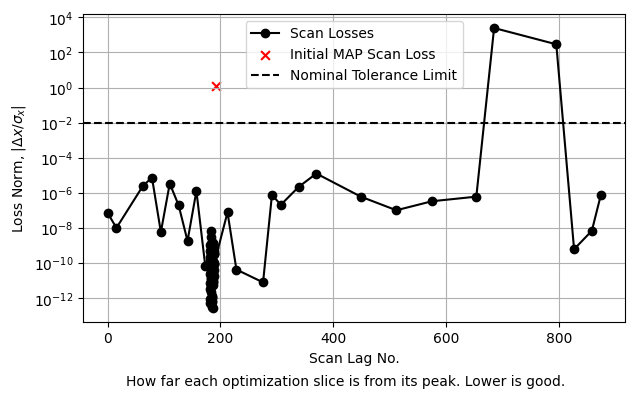

In [5]:
fitter.refit(mock.lc_1, mock.lc_2)
fitter.diagnostics(show=False)
plt.show()

Sadly, no. If we plot the recovered lag, we can see that our fitter has confidently honed in on a lag of $\Delta t = 184^{+2.2}_{-7.5} \; \mathrm{d}$, several dozen $\sigma$ from the true lag of $\Delta t = 256  \; \mathrm{d}$. We've converged but on the wrong answer!

Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. 

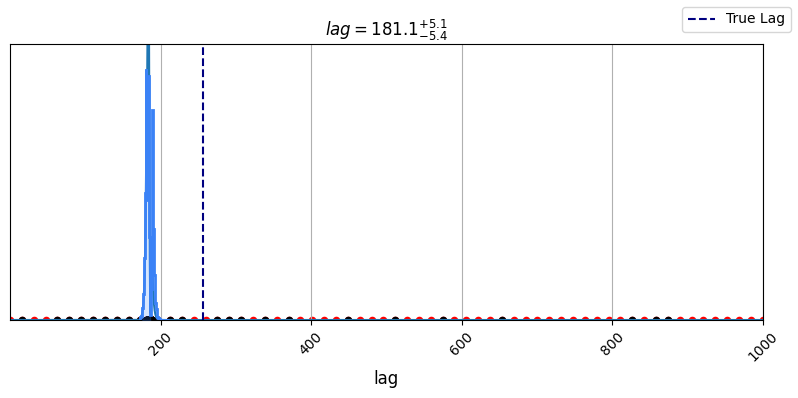

In [6]:
lt = LITMUS(fitter)
f = lt.lag_plot(show=False, prior_extents=True)
f.axes[0].axvline(mock.lag, ls="--", color="navy", label="True Lag"), f.legend()
plt.show()

## What's Gone Wrong?
Let's take a closer look with `diagnostic_lagplot`. Equipped with the true parameters we can see the issue: our test lag grid has completely missed the true lag, it's slipped between the gaps:

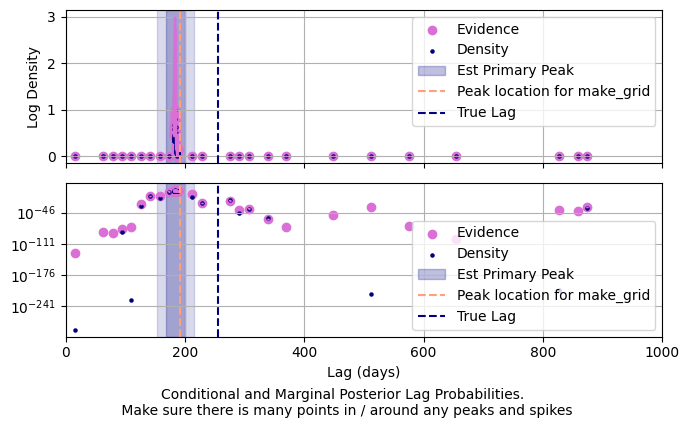

In [7]:
f = fitter.diagnostic_lagplot(show=False)
for ax in f.axes: ax.axvline(mock.lag, ls="--", color="navy", label="True Lag"), ax.legend()

Because we know the true parameters we can drill in even further. We can trace out the _conditional_ lag distribution with the other parameters fixed at both the _true_ parameters and our (failed) estimate of the MAP. Doing so we see what's gone wrong: in it's initial guesses the fitter has locked onto a shallower, wider mode at ~200 days. In lower SNR signals this is fine because the non-lag parameters are loosely constrained and can be used for different lags decently well, but in this high SNR signal the two lags correspond to different timescales / amplitudes etc and so the grid smoothing has failed:

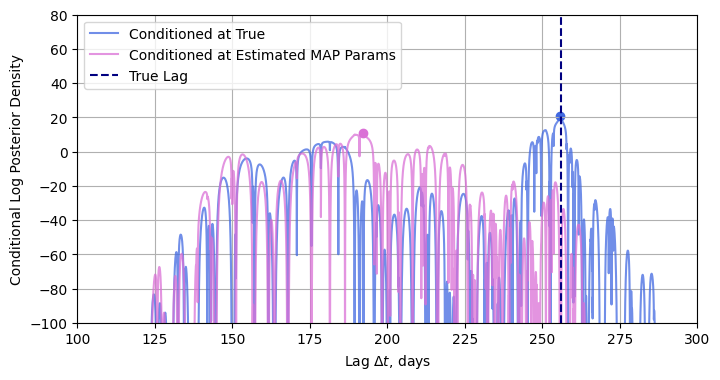

In [15]:
p1, p2 = mock.params(), fitter.estmap_params
p1, p2 = (litmus._utils.dict_extend(p, {"lag": np.linspace(100, 300, 10_000)}) for p in [p1, p2])
LL1, LL2 = [model_1.log_density(p, data) for p in [p1, p2]]

#------------------

plt.figure(figsize=(8, 4))
for p, LL, col, lab in zip([p1, p2], [LL1, LL2], ["royalblue", "orchid"], ["Conditioned at True", "Conditioned at Estimated MAP Params"]):
    I = p["lag"].argsort()
    X, Y = p["lag"][I], LL[I]
    plt.plot(X, Y, color=col, alpha=0.75, label=lab)
    plt.scatter(X[Y.argmax()], Y.max(), color=col, marker = "o", alpha=1.0)

plt.axvline(mock.lag, ls='--', color='navy', label="True Lag")
plt.legend()
plt.xlim(100, 300)
plt.ylim(-100, 80)
plt.ylabel("Conditional Log Posterior Density")
plt.xlabel("Lag $\Delta t$, days")
plt.grid()
plt.show()

## How to Fix It - Brute Force

1. **Use a denser sampling grid (decrease `grid_bunching` and increase `Nlags`)**
2. Use a more exhaustive sampler (e.g. `fitting_methods.nested_sampling`)
3. **Use different test lags**

In this example, we'll use the first and last methods. For examples how to use nested sampling in `LITMUS`, see other examples.

To start, let's take a brute force approach and scan with lots of lags. By increasing `Nlags` we test more slices and by lowering `grid_bunching` we spread them more evenly across the lag prior, thereby nullifying the impact of our mis-matched MAP estimate. This is _slower_, but not intractable as the smaller gaps between test lags means the solver has to adjust less as it moves between them.

Testing more lags also means testing more _bad_ lags which we intend to discard. For this reason I've lowered `maxiter` in the `optimizer_args`, telling the solver to abandon poor fitting lags early rather than waste too much time trying to make sense of them.

In [22]:
fitter = litmus.fitting_methods.hessian_scan(model_1, precondition="diag",
                                             verbose=4, debug=False, warn=False,
                                             Nlags=1024,
                                             grid_bunching=0.1,
                                             init_samples=10_000,
                                             optimizer_args={"maxiter": 128}
                                             )
fitter.fit(*mock.lcs())
fitter.refit(*mock.lcs())

Starting Hessian Scan 
Using stat model .find_seed to estimate some parameters 
Optimizing Non-Lag Params... 
Beginning scan at constrained-space position: 
	 lag: 	 192.30 
	 logtau: 	 7.26 
	 logamp: 	 0.49 
	 rel_amp: 	 0.96 
	 mean: 	 0.33 
	 rel_mean: 	 -0.26 
Log-Density for this is: 7.92 
Moving non-lag params to new location... 
Optimizer settled at new fit with log density 10.57: 
Optimizer settled at new fit: 
	 lag: 	 192.30 
	 logtau: 	 6.68 
	 logamp: 	 0.32 
	 rel_amp: 	 0.96 
	 mean: 	 0.55 
	 rel_mean: 	 -0.27 
Log-Density for this is: 10.57 
Finding a good lag with grid sweep... 
Grid finds good lag at 192.30: 
Log-Density for this is: 10.57 
Doing lag Optimization in isolation... 
Lag-only opt settled at new lag 192.33... 
Log-Density for this is: 10.80 
Running final optimization... 
Optimizer settled at new fit: 
	 lag: 	 192.33 
	 logtau: 	 6.68 
	 logamp: 	 0.32 
	 rel_amp: 	 0.96 
	 mean: 	 0.55 
	 rel_mean: 	 -0.27 
Log-Density for this is: 10.81 
Estimated to b

TypeError: GradientDescent.__init__() got an unexpected keyword argument 'increase_factor'

Checking the fitter's diagnostic plot, we see that it's got a lot of poorly converged lags, but that the properly converged ones now span the $100-300 \; \mathrm{d}$ range: 

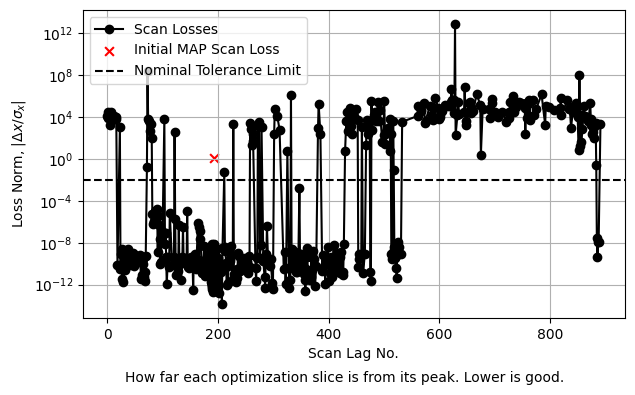

In [29]:
fitter.diagnostics(show=False)
plt.show()

Because we've searched the lag-prior near exhaustively, we've picked up the true lag peak _as well_ as the false positive from earlier. This comes at the cost of taking about $2-3$ times longer to run than our ICCF combination run, but also gives us a really high precision estimate of the evidence as we've mapped out a giant chunk of the posterior.

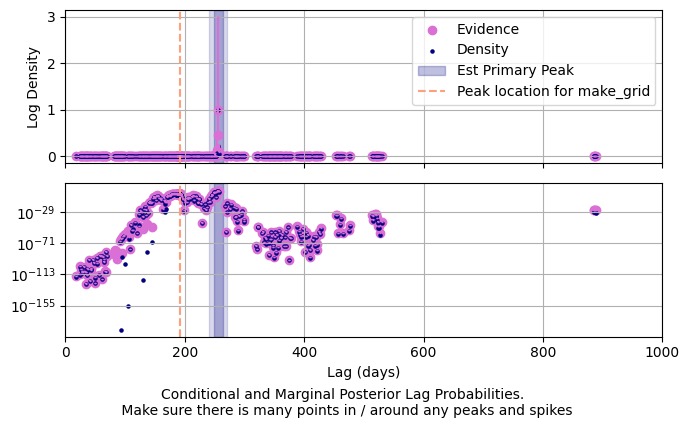

In [33]:
fitter.diagnostic_lagplot(show=False)
plt.show()

In [ ]:
lt = LITMUS(fitter)
lt.lag_plot(show=False)
plt.show()

## A More Elegant Solution - Manually Specifying Test Lags with ICCF

By default, `LITMUS` uses it's grid smoothing algorithm to select test lags for you, but you can over-ride this with whatever lags you so desire. All we need is some way of knowing what lags to direct our attention towards. Fortunately we have one on hand already: the frequentist ICCF method, happily already included in `LITMUS`'s available fitting methods.

We create an ICCF sampler and fire it off:

In [9]:
fitter_ICCF = fitting_methods.ICCF(model_1, verbose=False, debug=False, Nboot=1024)
fitter_ICCF.fit(mock.lc_1, mock.lc_2)

Checking the results of this sampler, we can see that it is still preferring shorter lags of $\approx 200 \; \mathrm{d}$, but its vagueness means that it broadly captures the true lag of $256 \; \mathrm{d}$:

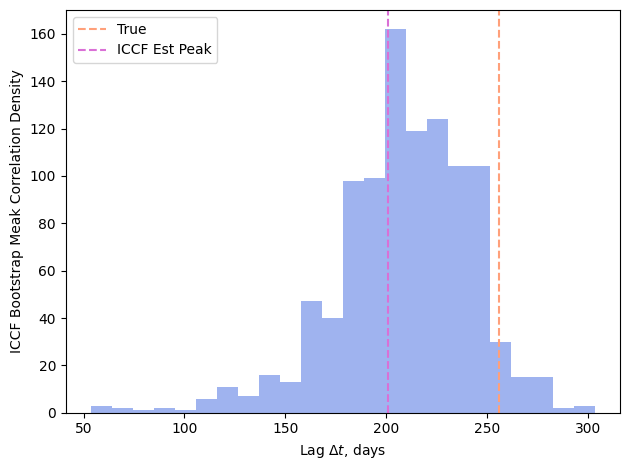

In [10]:
plt.hist(fitter_ICCF.get_samples()["lag"], bins=24, color='royalblue', alpha=0.5)
plt.axvline(mock.lag, ls='--', color='lightsalmon', label="True")
plt.axvline(fitter_ICCF.get_peaks()["lag"], ls='--', color='orchid', label="ICCF Est Peak")
plt.legend()
plt.xlabel("Lag $\Delta t$, days")
plt.ylabel("ICCF Bootstrap Meak Correlation Density")
plt.tight_layout()
plt.show()

Now we can grab our test lags _from_ the ICCF using `fitter_ICCF.get_samples()`, and then feed them into a new `hessian_scan` with the `test_lags` fitting parameter. Let's go with the same number of lags as our original run to keep things fair and fire it off:

In [11]:
test_lags = fitter_ICCF.get_samples(fitter.Nlags)["lag"]
fitter_testlags = litmus.fitting_methods.hessian_scan(model_1, precondition="diag",
                                               verbose=False, debug=False, warn=0,
                                               Nlags=fitter.Nlags,
                                               init_samples=10_000,
                                               optimizer_args={"maxiter": 256, "increase_factor": 1.2},
                                               test_lags=test_lags
                                               )
fitter_testlags.fit(mock.lc_1, mock.lc_2)
fitter_testlags.refit(mock.lc_1, mock.lc_2)

As usual, check to make sure this has actually converged:

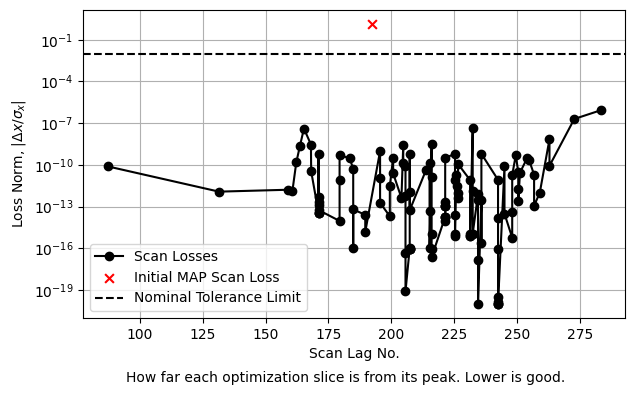

In [12]:
fitter_testlags.diagnostics(show=False)
plt.show()

And then, checking the parameters we recovered, we find that we're bang-on the true underlying parameters!

Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. 

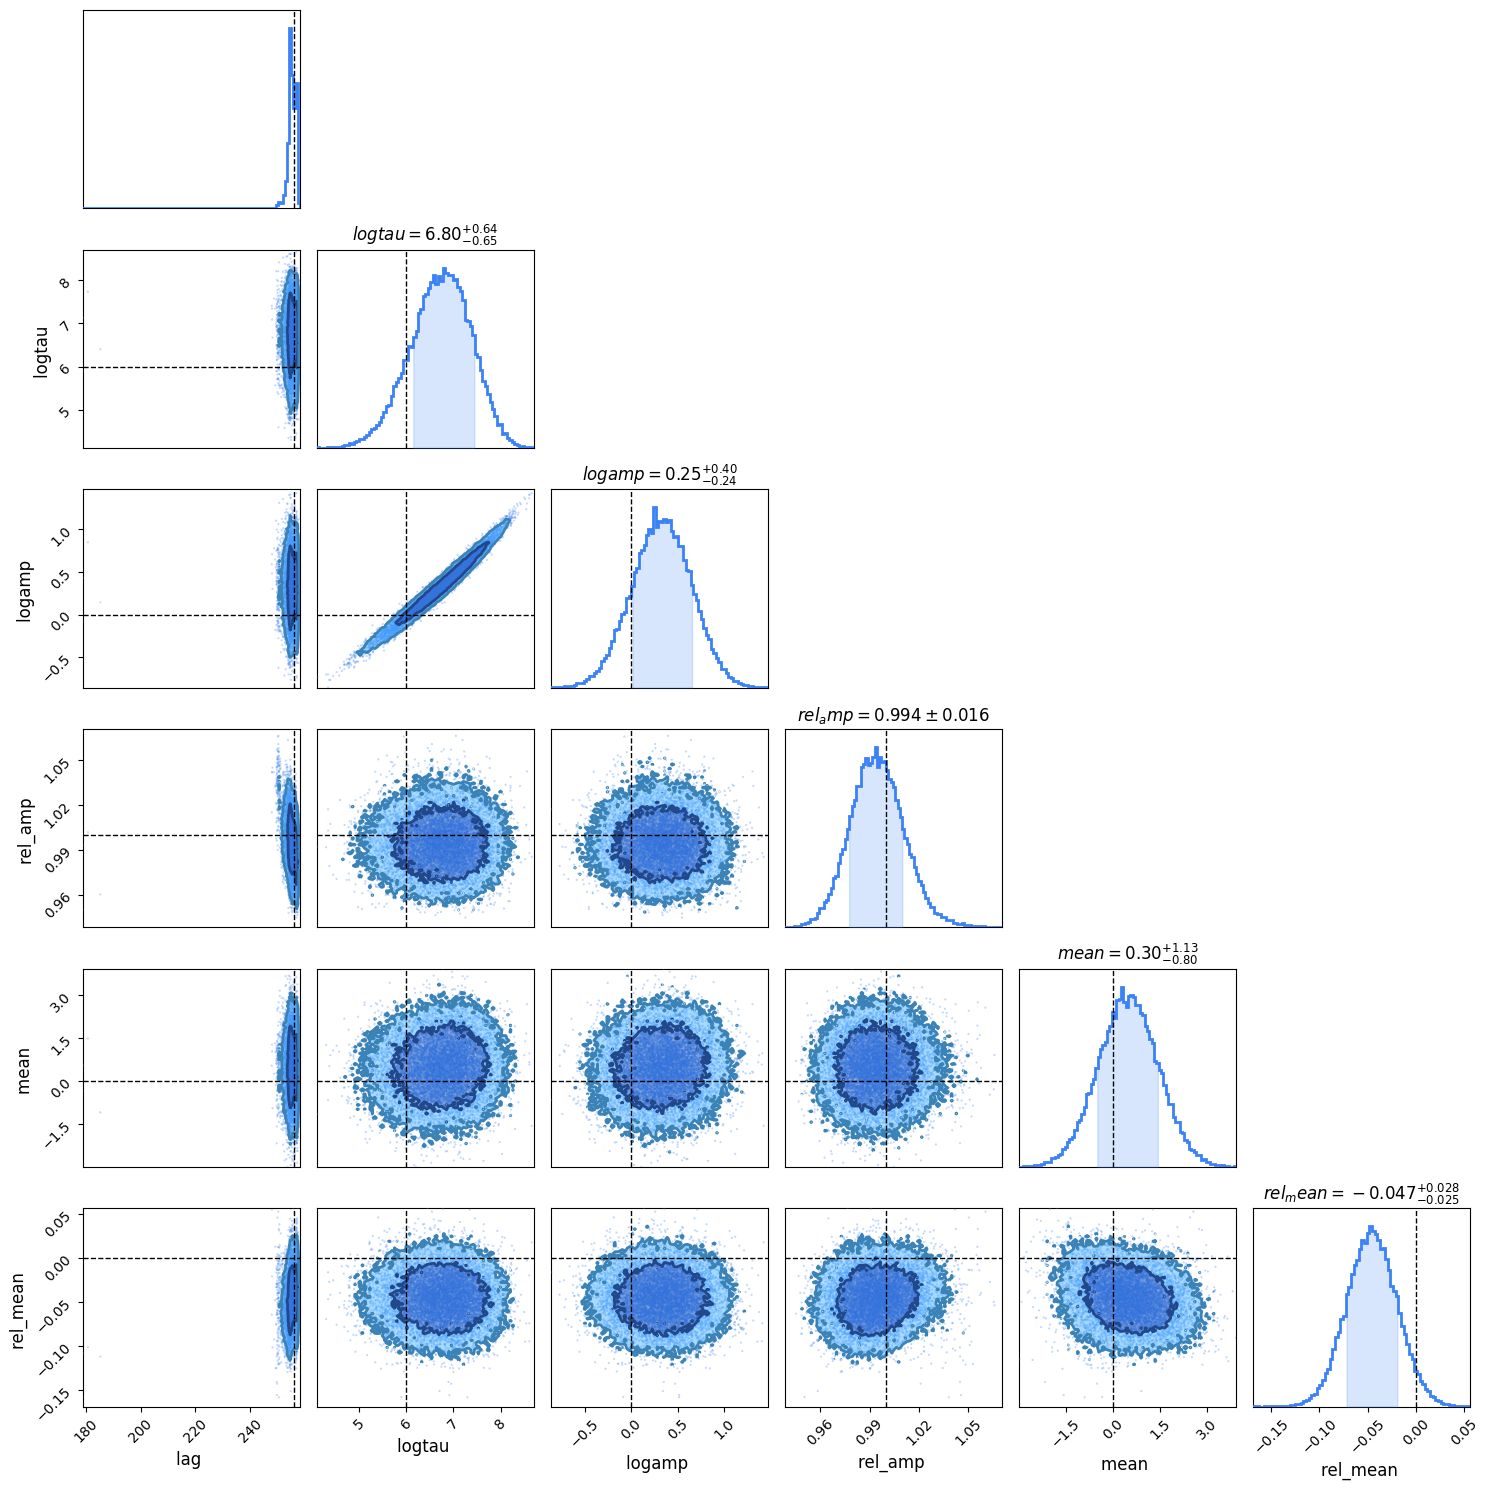

In [14]:
lt = LITMUS(fitter_testlags)
lt.plot_parameters(truth=mock.params(), prior_extents=False, show=False)
plt.show()

Including the time taken to run the ICCF fit, this is markedly faster than the brute force approach of testing more lags.

## When to be Worried
In this example we've seen that `LITMUS` can sometimes fail _under its default settings_ in some edge cases. As end users, how we do know when to be worried in the real world? Well there's a few warning signs we should look for to at lease raise our curiosity, if not concern:

1. Is the constrained lag really narrow? This tells us it's a high SNR signal and might be subject to these sorts of issues.
2. Is the lag at or near an aliasing lag? (In reverberation mapping that's half-yearly lags, e.g. $180, \; 540 \; \mathrm{d}$ etc.
3. If we do a plot of the conditional posterior, is the main peak located on a broad platuea that might contain other modes?